In [1]:
%matplotlib inline

sim time: 0.25
sim time: 0.1667
sim time: 0.125
sim time: 0.1
<class 'tuple'>
(0, 1, 2, 3, 4, 5, 6)
<class 'tuple'>
(0, 1, 2, 3, 4, 5, 6)
<class 'tuple'>
(0, 1, 2, 3, 4, 5, 6)
<class 'tuple'>
(0, 1, 2, 3, 4, 5, 6)


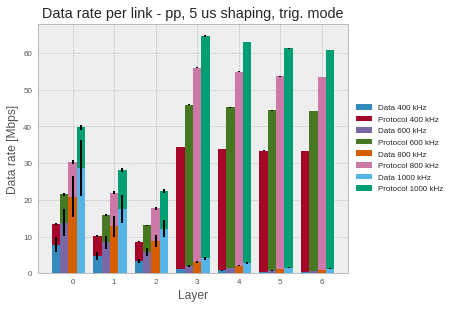

<class 'tuple'>
(0, 1, 2, 3, 4, 5, 6)
<class 'tuple'>
(0, 1, 2, 3, 4, 5, 6)
<class 'tuple'>
(0, 1, 2, 3, 4, 5, 6)
<class 'tuple'>
(0, 1, 2, 3, 4, 5, 6)


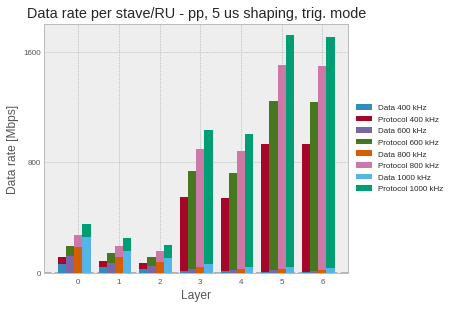

In [88]:
import numpy as np
import os
import csv
import configparser
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)


# proton-proton, triggered, 5 us shaping time
sim_dirs = ((400, '/scratch/systemc_sim_stuff/sim_output_pp/run_4/'),
            (600, '/scratch/systemc_sim_stuff/sim_output_pp/run_3/'),
            (800, '/scratch/systemc_sim_stuff/sim_output_pp/run_5/'),
            (1000,'/scratch/systemc_sim_stuff/sim_output_pp/run_6/'))
sim_type = "pp"
sim_additional_title = "pp, 5 us shaping, trig. mode"
plot_output_dir = '/scratch/systemc_sim_stuff/pp_plots/triggered_5us'

# PbPb, triggered, 5 us shaping time
#sim_dirs = ((50, '/scratch/systemc_sim_stuff/sim_output_PbPb/run_1/'),
#            (100, '/scratch/systemc_sim_stuff/sim_output_PbPb/run_6/'),
#            (150, '/scratch/systemc_sim_stuff/sim_output_PbPb/run_5/'),
#            (200,'/scratch/systemc_sim_stuff/sim_output_PbPb/run_3/'))
#sim_type = "PbPb"
#sim_additional_title = "PbPb, 5 us shaping, trig. mode"
#plot_output_dir = '/scratch/systemc_sim_stuff/PbPb_plots/triggered_5us'

save_plots = True

# Create plot output directory
if save_plots:
    if not os.path.exists(plot_output_dir):
        os.makedirs(plot_output_dir)

# Dict of dict:
# Outer most dict: key: event_rate, value: dict
# Inner most dict: key: layer, value: data rate
sim_data_mean = dict() # per link
sim_data_stddev = dict() # per link
sim_protocol_mean = dict() # per link
sim_protocol_stddev = dict() # per link
sim_total_data = dict() # total for stave/RU
sim_total_protocol = dict() # total for stave/RU

data_links_per_stave_per_layer = {0: 9,
                                  1: 9,
                                  2: 9,
                                  3: 16,
                                  4: 16,
                                  5: 28,
                                  6: 28}

for event_rate,dir in sim_dirs:
    # Check config, see how many staves per layer were simulated
    config = configparser.ConfigParser()
    config.read(dir + '/settings.txt')
    
    num_events = config.getint('simulation','n_events')
    avg_event_rate_ns = config.getint('event','average_event_rate_ns')
    sim_time_ns = num_events*avg_event_rate_ns
    sim_time_seconds = sim_time_ns/1.0E9
    
    print('sim time: ' + str(sim_time_seconds))
    
    dict_data_mean = dict()
    dict_data_stddev = dict()
    dict_protocol_mean = dict()
    dict_protocol_stddev = dict()
    dict_total_data = dict()
    dict_total_protocol = dict()
    
    for layer in range(7):
        num_staves = config.getint('its','layer' + str(layer) + '_num_staves')    
    
        if num_staves == 0:
            dict_data_mean[layer] = 0
            dict_data_stddev[layer] = 0
            dict_protocol_mean[layer] = 0
            dict_protocol_stddev[layer] = 0
            dict_total_data[layer] = 0
            dict_total_protocol[layer] = 0
        else:
            links_per_stave = data_links_per_stave_per_layer[layer]
            
            data_per_link_arr = np.zeros(links_per_stave*num_staves)
            protocol_per_link_arr = np.zeros(links_per_stave*num_staves)
            
            for stave in range(num_staves):
                # Open link utilization file for current layer/stave
                with open(dir + '/RU_' + str(layer) + '_' + str(stave) + '_Link_utilization.csv') as csv_file:
                    csv_reader = csv.DictReader(csv_file, delimiter=';')
                    link_num = 0
                    for row in csv_reader:
                        data_bytes = int(row['DATA_SHORT (bytes)']) + \
                                     int(row['DATA_LONG (bytes)']) + \
                                     int(row['REGION_HEADER (bytes)'])
                        
                        protocol_bytes = int(row['CHIP_HEADER (bytes)']) + \
                                         int(row['CHIP_TRAILER (bytes)']) + \
                                         int(row['CHIP_EMPTY_FRAME (bytes)']) + \
                                         int(row['BUSY_ON (bytes)']) + \
                                         int(row['BUSY_OFF (bytes)'])
                        
                        #print('Layer: ' + str(layer) + ' stave: ' + str(stave) + ' link: ' + str(link_num))
                        
                        data_mbps = (float(data_bytes) * 8) / (1.0E6 * sim_time_seconds)
                        protocol_mbps = (float(protocol_bytes) * 8) / (1.0E6 * sim_time_seconds)
                        
                        #data_mbps = (float(data_bytes) * 8) / ((1024*1024) * sim_time_seconds)
                        #protocol_mbps = (float(protocol_bytes) * 8) / ((1024*1024) * sim_time_seconds)
                        
                        data_per_link_arr[stave*links_per_stave + link_num] = data_mbps
                        protocol_per_link_arr[stave*links_per_stave + link_num] = protocol_mbps
                        
                        link_num += 1
            
            # Data per link per layer
            dict_data_mean[layer] = np.mean(data_per_link_arr)                        
            dict_data_stddev[layer] = np.std(data_per_link_arr)
            dict_protocol_mean[layer] = np.mean(protocol_per_link_arr)                        
            dict_protocol_stddev[layer] = np.std(protocol_per_link_arr)
            
            # Avg data per stave/RU per layer
            # Maybe I should calculate stddev here as well..
            dict_total_data[layer] = np.sum(data_per_link_arr)/num_staves
            dict_total_protocol[layer] = np.sum(protocol_per_link_arr)/num_staves
    
    sim_data_mean[event_rate] = dict_data_mean
    sim_data_stddev[event_rate] = dict_data_stddev
    sim_protocol_mean[event_rate] = dict_protocol_mean
    sim_protocol_stddev[event_rate] = dict_protocol_stddev
    sim_total_data[event_rate] = dict_total_data
    sim_total_protocol[event_rate] = dict_total_protocol
    


# Plot data rate per link

fig, ax = plt.subplots()

#plt.style.use('ggplot')
#plt.style.use('seaborn-paper')
plt.style.use('bmh')

width = (1.0/len(sim_dirs)) * 0.8

plots_data = dict()
plots_protocol = dict()


plot_num = 0
for event_rate in sim_data_mean:
    list_data_mean = sorted(sim_data_mean[event_rate].items())
    list_data_stddev = sorted(sim_data_stddev[event_rate].items())
    list_protocol_mean = sorted(sim_protocol_mean[event_rate].items())
    list_protocol_stddev = sorted(sim_protocol_stddev[event_rate].items())

    layers, data_mean = zip(*list_data_mean)
    layers, data_stddev = zip(*list_data_stddev)
    layers, protocol_mean = zip(*list_protocol_mean)
    layers, protocol_stddev = zip(*list_protocol_stddev)
    
    print(type(layers))
    print(layers)
    
    layers_arr = np.array(layers)
    
    plots_data[event_rate] = plt.bar(layers_arr + (plot_num-len(sim_dirs)/2)*width, data_mean, width,
                                     yerr=data_stddev, label='Data ' + str(event_rate) + ' kHz')
    
    plots_protocol[event_rate] = plt.bar(layers_arr + (plot_num-len(sim_dirs)/2)*width, protocol_mean, width,
                                         bottom=data_mean, yerr=protocol_stddev, label='Protocol '  + str(event_rate) + ' kHz')

    plot_num += 1


additional_title = ''
if len(sim_additional_title) > 0:
    additional_title = ' - ' + sim_additional_title

#ax.set_yscale('log')
plt.title('Data rate per link' + additional_title)
plt.xlabel('Layer')
plt.ylabel('Data rate [Mbps]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#ax.yaxis.set_major_locator(MultipleLocator(100))
#ax.yaxis.grid(True, which='minor')
#ax.yaxis.set_minor_locator(MultipleLocator(50))

plt.tight_layout()
plt.show()

if save_plots:
    fig.savefig(plot_output_dir + '/data_rates_per_link.png', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
    fig.savefig(plot_output_dir + '/data_rates_per_links.pdf', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
plt.close(fig)



# Plot data rate per stave/RU

fig, ax = plt.subplots()

plots_total_data = dict()
plots_total_protocol = dict()
plot_num = 0

for event_rate in sim_data_mean:
    list_total_data = sorted(sim_total_data[event_rate].items())
    list_total_protocol = sorted(sim_total_protocol[event_rate].items())

    layers, data_total = zip(*list_total_data)
    layers, protocol_total = zip(*list_total_protocol)
    
    print(type(layers))
    print(layers)
    
    layers_arr = np.array(layers)

    plots_total_data[event_rate] = plt.bar(layers_arr + (plot_num-len(sim_dirs)/2)*width, data_total, width,
                                           label='Data ' + str(event_rate) + ' kHz')
    
    plots_total_protocol[event_rate] = plt.bar(layers_arr + (plot_num-len(sim_dirs)/2)*width, protocol_total, width,
                                               bottom=data_total, label='Protocol ' + str(event_rate) + ' kHz')

    plot_num += 1
    
    
#ax.set_yscale('log')
plt.title('Data rate per stave/RU' + additional_title)
plt.xlabel('Layer')
plt.ylabel('Data rate [Mbps]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.yaxis.grid(True, which='major', linewidth=2)
ax.yaxis.set_major_locator(MultipleLocator(3200))
ax.yaxis.set_major_formatter(NullFormatter())
ax.yaxis.grid(True, which='minor')
ax.yaxis.set_minor_locator(MultipleLocator(800))
ax.yaxis.set_minor_formatter(FormatStrFormatter('%d'))

plt.tight_layout()
plt.show()

if save_plots:
    fig.savefig(plot_output_dir + '/data_rates_per_stave.png', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
    fig.savefig(plot_output_dir + '/data_rates_per_stave.pdf', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
plt.close(fig)